In [8]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import pyroms

import scipy.interpolate as interp
from datetime import datetime 
from datetime import timedelta

# Create ARGO observations for OSSE

Using the WMOP forecast as a nature run for our OSSE experiment we are going to prepare the sinthetic observations for Assimilation

- The period of the experiment is the same as the OSE HFradar assimilation experiments previosuly realized (20 September to 20 October 2014)

- WMOP forecast used as Nature run. For the period selected the model, by coincidence, was not restarted from and thus we have a continuos free run, as we liked to.  In the future using WMOP hindcast MERCATOR as NR may be considered

- Observations from real sources will be simulated by interpolating the NR field to the observation points. Histogram of innovations (difference between virtual observation and model) should be regarded and compared against the innovations of the real observations 

- Virtual HF radar antennas in Denia will be simulated by supossing a virtual rdar footprint and considering the observations of the surface velocitu fields within it, considering also possible gaps in the coverage area
                                                                                                        

In [9]:
obs_path = '/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_all_nudging_Oct2014/'
nr_path = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch/'

In [10]:
obsfile = glob(obs_path + '*obs')
obsfile.sort()

df = tools.read_obsfile(obsfile[0])

In [11]:
strdate = '20140920'

file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)

# Subset Altimetry Observations
df_t = df[(df['var']=='t') & (df['source']=='ARGO')]
df_s = df[(df['var']=='s') & (df['source']=='ARGO')]

# Subset Altimetry Observations
df_argo = df[df['source']=='ARGO']

In [12]:
grid = pyroms.grid.get_ROMS_grid('wmop', hist_file=file_wmop, grid_file=file_wmop)

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


In [13]:
z_r = grid.vgrid.z_r[:]

## Interpolate WMOP  Nature Run to Argo position

In [7]:
# Interpolate WMOP Nature Run to Argo position

t0 = datetime.now()

# Subset Argo Observations by variable measured
df_t = df[(df['var']=='t') & (df['source']=='ARGO')]
df_s = df[(df['var']=='s') & (df['source']=='ARGO')]

# Get unique values of latitude and longitude to identify different profiles
lonlat = df_t[['lon', 'lat']].drop_duplicates()
lonlat = df_t[['lon', 'lat','year', 'month', 'day', 'hour', 'minute']].drop_duplicates().reset_index(drop=True)
lon_wmop = ds_wmop.lon_rho.values[1,:]
lat_wmop = ds_wmop.lat_rho.values[:,1]

# Get id of value of the WMOP grid closest to Argo profile
id_lon = [np.abs(lon_wmop-lonlat.iloc[i].lon).argmin() for i in range(len(lonlat))] 
id_lat = [np.abs(lat_wmop-lonlat.iloc[i].lat).argmin() for i in range(len(lonlat))] 

# Create new DataFrame to fill in wih synthetic interpolated values
df_argo_new = pd.DataFrame(columns=['var', 'source', 'year', 'month', 'day', 'hour', 'minute', 'lon', 'lat',
       'depth', 'val', 'err', 'rep','val2'])

for i in range(len(id_lon)):
    
    date_obs = datetime(int(lonlat.iloc[i]['year']), int(lonlat.iloc[i]['month']), int(lonlat.iloc[i]['day']), int(lonlat.iloc[i]['hour']), int(lonlat.iloc[i]['minute']))
    strdate_obs = date_obs.strftime('%Y%m%d')
    
    # Load NR file to extract observations from
    file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate_obs)
    ds_wmop = xr.open_dataset(file_wmop)
    
    # Get time slot to extract obs from
    dt = np.diff(ds_wmop.ocean_time.values) / np.timedelta64(1, 'h')
    dt = int(np.unique(dt))
    idt = date_obs.hour // dt

    # Extract Temperatures for WMOP and Argo profiles
    df1 = df_t[(df_t.lon==lonlat.iloc[i].lon) & (df_t.lat==lonlat.iloc[i].lat)].reset_index(drop=True)
    df2 = df_s[(df_s.lon==lonlat.iloc[i].lon) & (df_s.lat==lonlat.iloc[i].lat)].reset_index(drop=True)

    temp_argo = df1['val'].values
    salt_argo = df2['val'].values
    zeta_temp = df1['depth'].values
    zeta_salt = df2['depth'].values

    # Get model profiles at closest location
    zeta_roms = z_r[:,id_lat[i], id_lon[i]]
    temp_wmop = ds_wmop.temp.values[idt,:, id_lat[i], id_lon[i]]
    salt_wmop = ds_wmop.salt.values[idt,:, id_lat[i], id_lon[i]]

    # Interpolae model to Argo depths
    temp_interp = [np.interp( -z, zeta_roms, temp_wmop)  for z in zeta_temp]
    salt_interp = [np.interp( -z, zeta_roms, salt_wmop)  for z in zeta_salt]

    # Substitute Argo values by synthetic observations in subset DataFrame
    df1['val2'] = temp_interp
    df2['val2'] = salt_interp

    # COncatenate interpolated observations to create new DataFrame
    df_argo_new = pd.concat([df_argo_new, df1, df2]).reset_index(drop=True)

tf = datetime.now()
print(' Tiempo total = {0} seconds'.format((tf-t0).total_seconds()))

 Tiempo total = 77.922622 seconds


### Plot profiles 

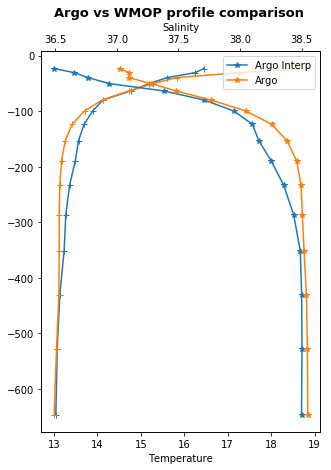

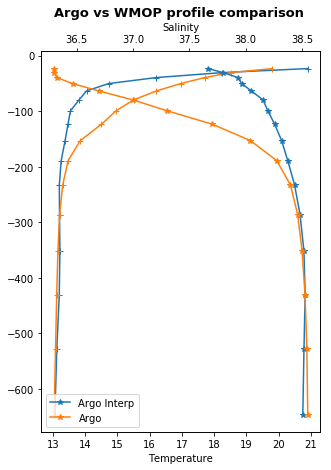

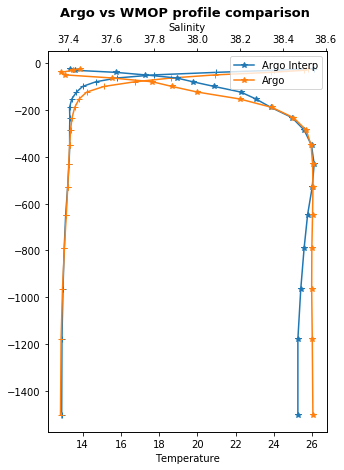

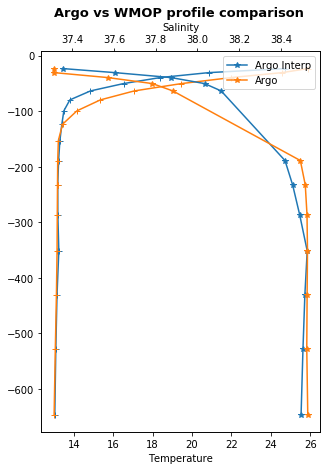

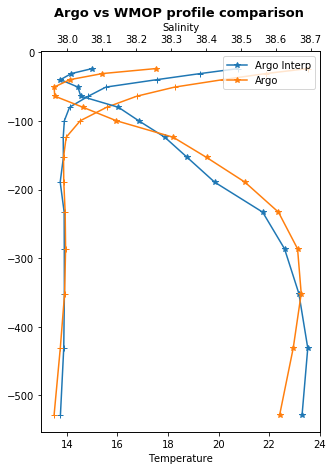

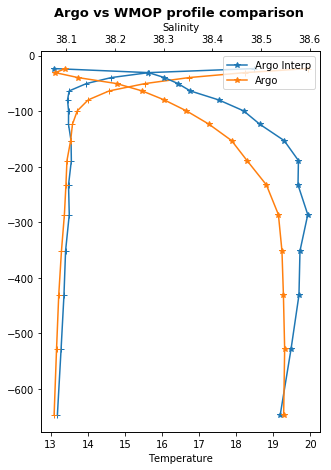

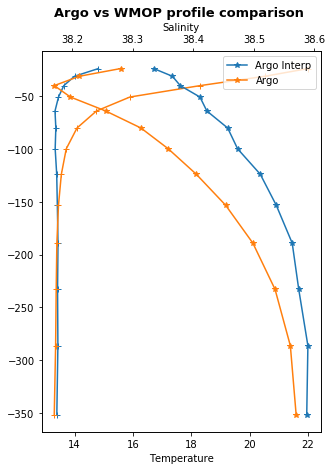

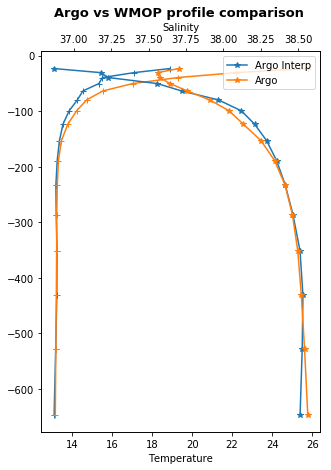

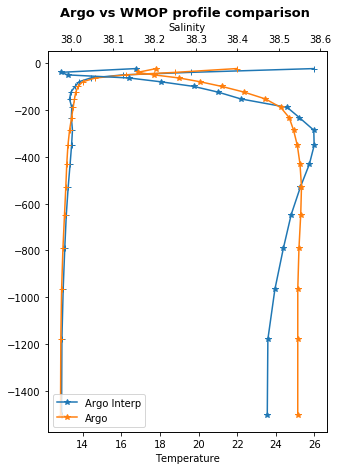

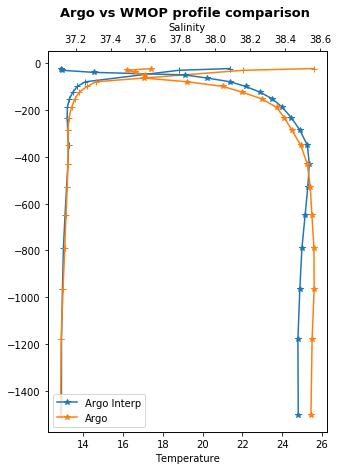

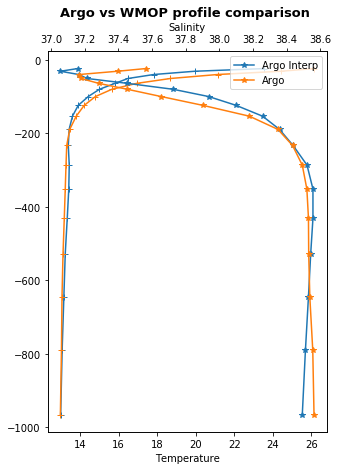

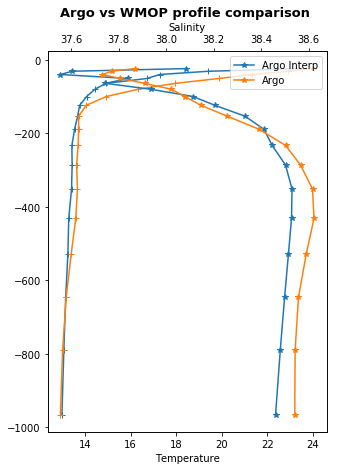

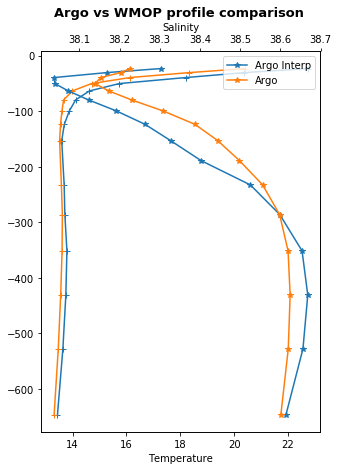

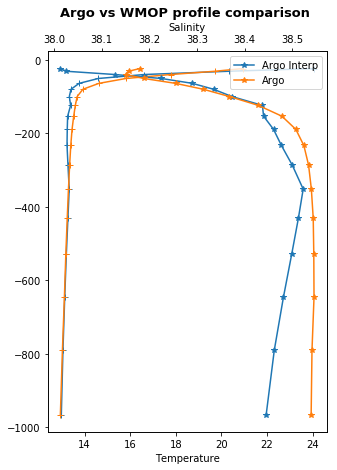

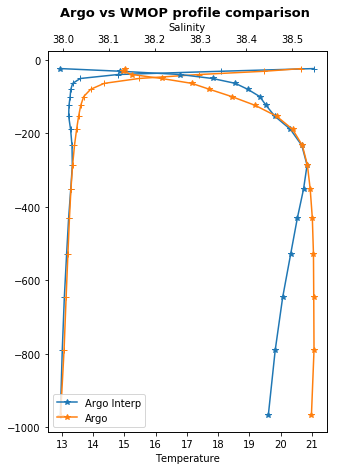

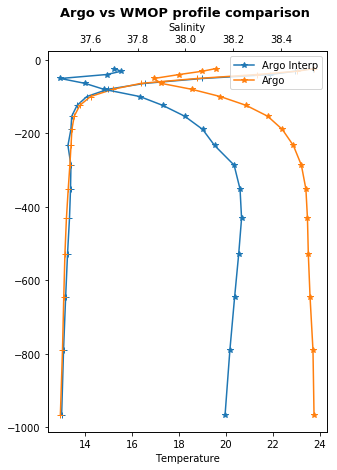

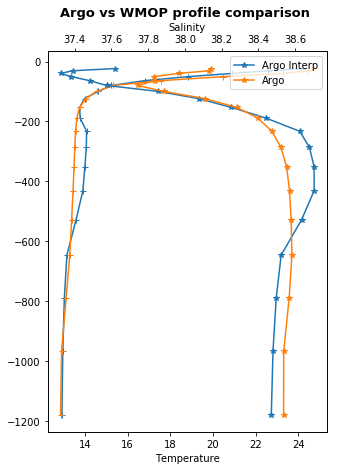

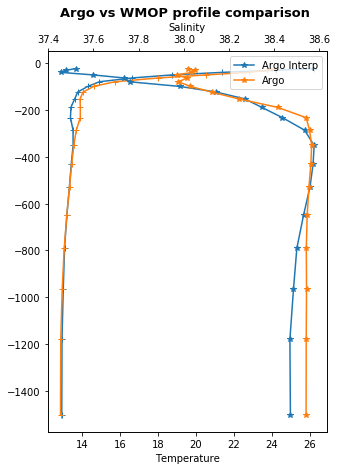

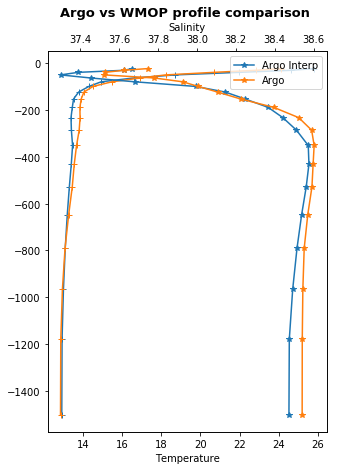

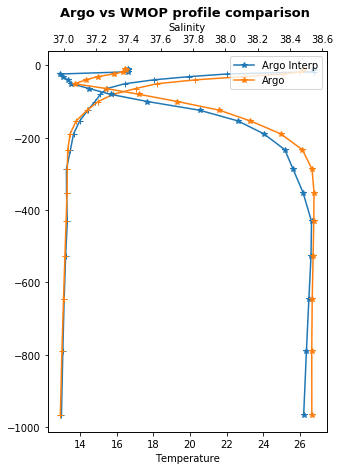

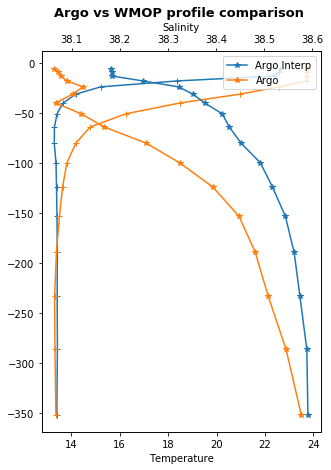

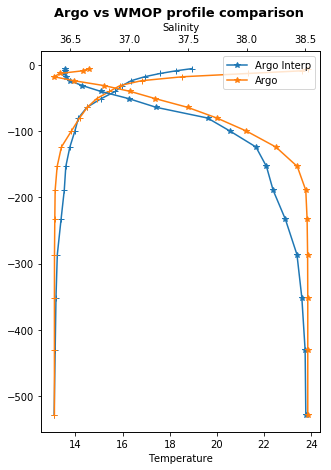

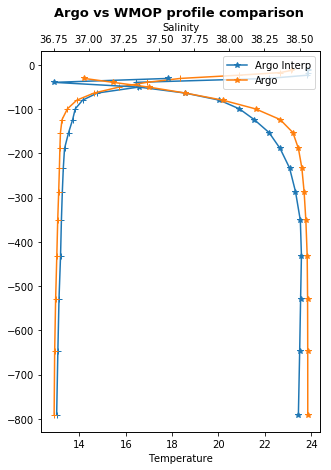

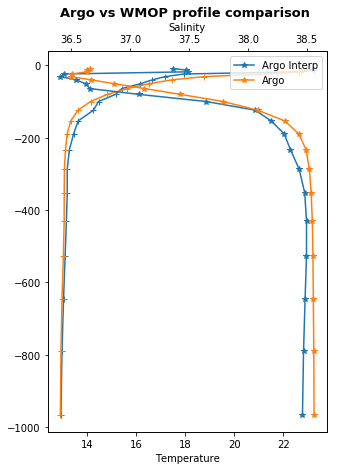

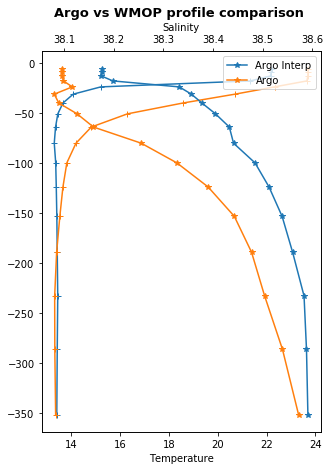

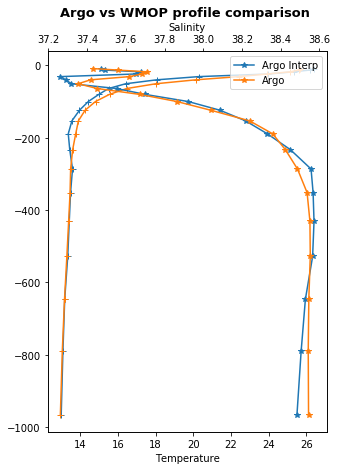

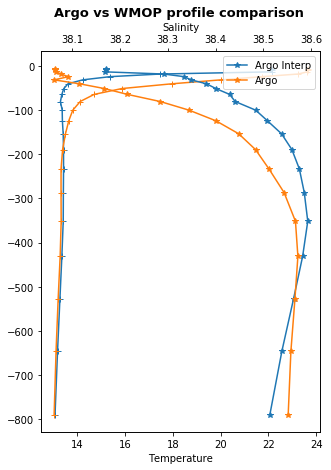

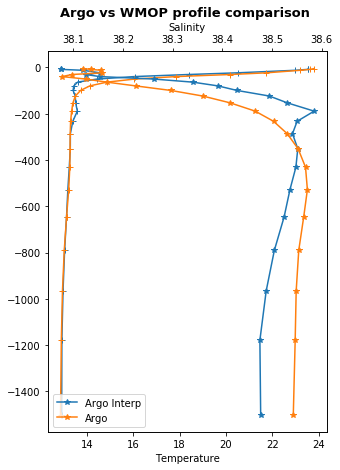

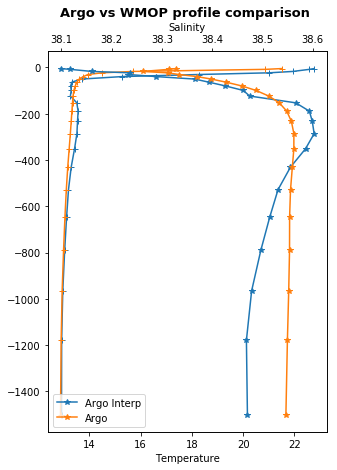

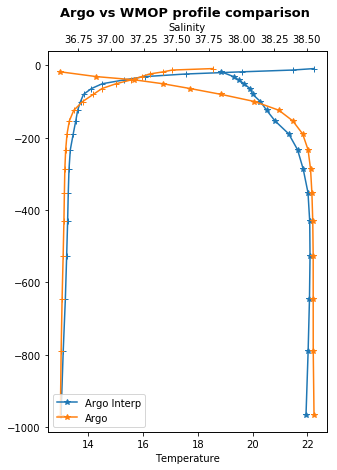

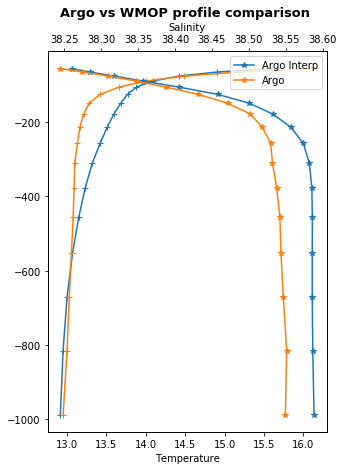

In [86]:

for i in range(len(id_lon)):

    df1 = df_argo[(df_argo.lon==lonlat.iloc[i].lon) & (df_argo.lat==lonlat.iloc[i].lat)].reset_index(drop=True)
    df2 = df_argo_new[(df_argo_new.lon==lonlat.iloc[i].lon) & (df_argo_new.lat==lonlat.iloc[i].lat)].reset_index(drop=True)
    
    #ax1 = plt.figure(figsize=(10,8))
    fig, ax1 = plt.subplots(figsize=(5,7))
    
    ax1.plot(df1['val'][df1['var']=='t'], -df1['depth'][df1['var']=='t'],'+-')
    ax1.plot(df2['val2'][df2['var']=='t'], -df2['depth'][df2['var']=='t'],'+-')
    
    #plt.legend(['Argo Interp','Argo'])
    #plt.ylim([-30,0])
    
    ax1.set_xlabel('Temperature')
    
    ax2 = ax1.twiny()
    ax2.plot(df1['val'][df1['var']=='s'], -df1['depth'][df1['var']=='s'],'*-')
    ax2.plot(df2['val2'][df2['var']=='s'], -df2['depth'][df2['var']=='s'],'*-')

    plt.legend(['Argo Interp','Argo'])
    #plt.ylim([-30,0])
    plt.title('Argo vs WMOP profile comparison ', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Salinity')
    
    plt.show()

## Histogram of Salnity observations

In [14]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

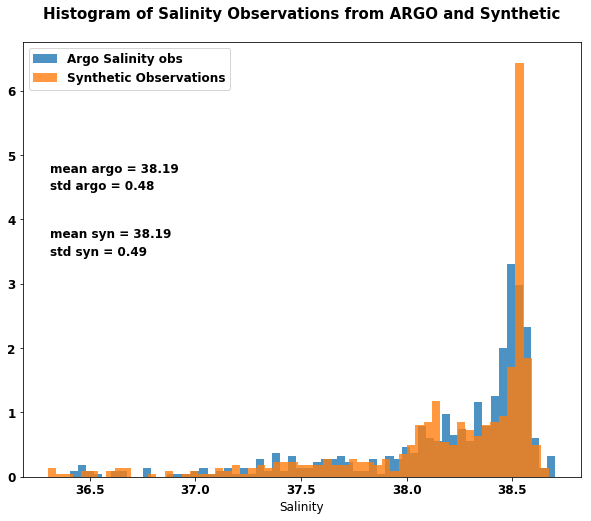

In [16]:
fig_salt_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_argo['val'][df_argo['var']=='s'], 60, density=True, alpha=0.8)
plt.hist(df_argo_new['val2'][df_argo_new['var']=='s'], 60, density=True, alpha=0.8)

plt.legend(['Argo Salinity obs', 'Synthetic Observations'])
plt.title('Histogram of Salinity Observations from ARGO and Synthetic\n', fontsize=15, fontweight='bold')
plt.xlabel('Salinity')

plt.text(0.05, 0.7, 'mean argo = {0:0.2f}'.format(np.mean(df_argo['val'][df_argo['var']=='s'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std argo = {0:0.2f}'.format(np.std(df_argo['val'][df_argo['var']=='s'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(df_argo_new['val2'][df_argo_new['var']=='s'])), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.2f}'.format(np.std(df_argo_new['val2'][df_argo_new['var']=='s'])), transform=ax.transAxes)


plt.show()

In [17]:
fig_salt_hist.savefig('/home/jhernandez/Escritorio/histogram_argo_salt_observations_OSSE.png', dpi=250)

## Histogram of Temperature observations

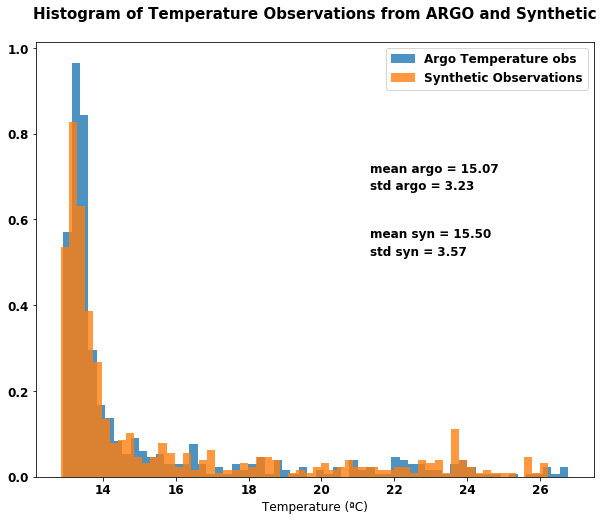

In [18]:
fig_temp_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_argo['val'][df_argo['var']=='t'], 60, density=True, alpha=0.8)
plt.hist(df_argo_new['val2'][df_argo_new['var']=='t'], 60, density=True, alpha=0.8)

plt.legend(['Argo Temperature obs', 'Synthetic Observations'])
plt.title('Histogram of Temperature Observations from ARGO and Synthetic\n', fontsize=15, fontweight='bold')
plt.xlabel('Temperature (ªC)')

plt.text(0.6, 0.7, 'mean argo = {0:0.2f}'.format(np.mean(df_argo['val'][df_argo['var']=='t'])), transform=ax.transAxes)
plt.text(0.6, 0.66, 'std argo = {0:0.2f}'.format(np.std(df_argo['val'][df_argo['var']=='t'])), transform=ax.transAxes)

plt.text(0.6, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(df_argo_new['val2'][df_argo_new['var']=='t'])), transform=ax.transAxes)
plt.text(0.6, 0.51, 'std syn = {0:0.2f}'.format(np.std(df_argo_new['val2'][df_argo_new['var']=='t'])), transform=ax.transAxes)



plt.show()

In [19]:
fig_temp_hist.savefig('/home/jhernandez/Escritorio/histogram_argo_temp_observations_OSSE.png', dpi=250)

In [107]:
print('Stats of Temperature Observations\n')
print(df_argo_new[df_argo_new['var']=='t'][['val','val2']].describe())

print('\nStats of Salinity Observations\n')
print(df_argo_new[df_argo_new['var']=='s'][['val','val2']].describe())


Stats of Temperature Observations

              val        val2
count  569.000000  569.000000
mean    15.070122   15.498981
std      3.228610    3.569414
min     12.906770   12.844717
25%     13.264292   13.220225
50%     13.503226   13.640159
75%     15.157592   16.248293
max     26.775820   26.228848

Stats of Salinity Observations

              val        val2
count  562.000000  562.000000
mean    38.188846   38.188077
std      0.477187    0.489092
min     36.406586   36.301637
25%     38.072083   38.065022
50%     38.382082   38.391807
75%     38.510245   38.539004
max     38.703152   38.673170
